Scott Kelley, from SDSU, observed a difference in the way men and women age in the American Gut population. Let's examine that effect.

In [84]:
import os

from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats
import skbio
import statsmodels.formula.api as smf

import americangut.ag_dictionary as agdic
import americangut.notebook_environment as agenv
from americangut.ag_data import AgData

% matplotlib inline

# Formats the axes using seabron so they will be white, and have ticks
# on the bottom of the axes.
sn.set_style('ticks', {'axes.facecolor': 'none', 'xtick.direction': 'in', 'ytick.direction': 'in'})

# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

Let's start by selecting the dataset we wish to use. For the American Gut paper, other analyses have used the healthy subset of adults (20-69, BMI 18.5-30, no hsitory of IBD, diabetes, or antibiotics in the past year) using the trimmed sequences at 10k rarefaction depth. We use a single sample per individual, to account for bais due to multiple samples from the same person.

In [67]:
bodysite = 'fecal'
trim = '100nt'
depth = '10k'

use_subset = False
use_one_sample = True

Next, we'll load the data, and remove outliers.

In [3]:
fecal_data = AgData(bodysite=bodysite, 
                    trim=trim, 
                    depth=depth, 
                    sub_participants=use_subset, 
                    one_sample=use_one_sample)

fecal_data.drop_alpha_outliers()
fecal_data.drop_bmi_outliers()

We're going to be analyzing data using the `AGE_CORRECTED` field.

In [4]:
age = agdic.ag_dictionary('AGE_CORRECTED')
fecal_data.clean_group(age)

Next, let's pick our metric.

In [5]:
metric = 'PD_whole_tree'

Let's write a quick function which will let us make a consistent plot.

In [167]:
def plot_ages(ax, ids, xlim, show_x=True, show_y=True, xticks=None):
    sn.regplot(
        x='AGE_CORRECTED', 
        y='PD_whole_tree_10k', 
        data=fecal_data.map_.loc[ids],
        ax=ax,
        color=sn.xkcd_rgb['scarlet'],
#         color='k',
        line_kws={'linewidth': 1.5},
        scatter_kws={'s': 30, 'linewidths': 1, 'edgecolors': [0.6, 0.6, 0.6], 'facecolors': 'None'}
        )
    
    ax.set_xlim(xlim[0], xlim[1])
    if xticks is not None:
        ax.set_xticks(xticks)
    if show_x:
        ax.set_xticklabels(map(int, ax.get_xticks()), size=12)
    else:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    
    ax.set_ylim([5, 55])
    ax.set_yticks(np.arange(10, 56, 10))
    if show_y:
        ax.set_yticklabels(map(int, ax.get_yticks()), size=12)
    else:
        ax.set_yticklabels('')
    ax.set_ylabel('')

Let's start by plotting all the data, and showing the regression line.

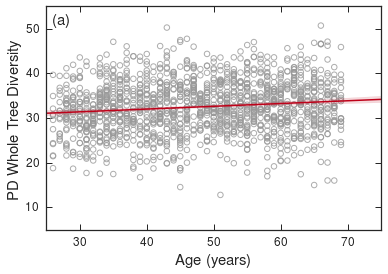

In [176]:
ax = plt.axes()
ids = (fecal_data.map_.AGE_CORRECTED.apply(lambda x: 25 < x < 75) & 
       fecal_data.map_.SEX.apply(lambda x: x in {'female', 'male'}))
plot_ages(ax, ids, [25, 75])

ax.set_xlabel('Age (years)', size=15)
ax.set_ylabel('PD Whole Tree Diversity', size=15)

ax.text(26, 51, '(a)', size=15)

fig = ax.figure
fig.savefig('/Users/jwdebelius/Desktop/alpha_trace_all.pdf')

Let's now use seaborn to evaluate the slope we've plotted. There is a formula API we'll use here.

In [177]:
model = smf.ols('PD_whole_tree_10k ~ AGE_CORRECTED', data=fecal_data.map_.loc[ids]).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:      PD_whole_tree_10k   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     23.96
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           1.09e-06
Time:                        15:44:39   Log-Likelihood:                -4656.2
No. Observations:                1467   AIC:                             9316.
Df Residuals:                    1465   BIC:                             9327.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        29.5253      0.625     47.215

Let's check if sex has an effect on the microbiome in the regression by adding it into the model.

Next, let's plot age as a function of gender, and fit the models.

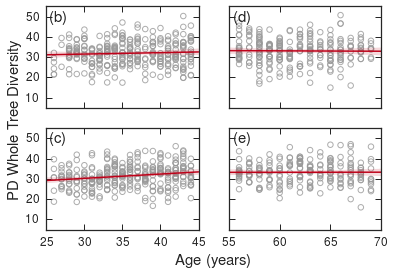

In [182]:
slopes = {}
fig = plt.figure()

des = {(0, 0): '(b)',
       (0, 1): '(c)',
       (1, 0): '(d)',
       (1, 1): '(e)',
      }

for idx, (lo, hi) in enumerate([[25, 45], [55, 70]]):
    for idy, sex in enumerate(['female', 'male']):
        f_ = lambda x : lo < x < hi
        # Gets the data set
        id_ = (fecal_data.map_[age.name].apply(f_)) & (fecal_data.map_.SEX == sex)
    
        ax = fig.add_subplot(2, 2, idy*2 + idx + 1)
        
        plot_ages(ax, id_, [lo, hi], show_x=(idy==1), show_y=(idx==0), xticks=np.arange(lo, hi+1, 5))
        model = smf.ols('PD_whole_tree_10k ~ AGE_CORRECTED', data=fecal_data.map_.loc[id_]).fit()
        slopes[(sex, '%i-%i' % (lo, hi))] = {
            'parameter': model.params['AGE_CORRECTED'],
            'p_value': model.pvalues['AGE_CORRECTED'],
            'ci_lo': model.conf_int().loc['AGE_CORRECTED', 0],
            'ci_hi': model.conf_int().loc['AGE_CORRECTED', 1],
            }
        
        ax.text(lo+0.5, 48, des[(idx, idy)], size=15)
xl = fig.axes[1].set_xlabel('Age (years)', size=15)
yl = fig.axes[1].set_ylabel('PD Whole Tree Diversity', size=15)

xl.set_position((1.1, 0.5))
yl.set_position((0.5, 1.1))

fig = ax.figure
fig.savefig('/Users/jwdebelius/Desktop/alpha_trace_all.pdf')

Finally, let's show the model tables for the slopes and p values.

In [157]:
pd.DataFrame.from_dict(slopes).transpose()[['p_value', 'parameter', 'ci_lo', 'ci_hi']]

p_value  parameter     ci_lo     ci_hi
female 25-45  0.292927   0.070173 -0.060895  0.201242
       55-70  0.855974  -0.019330 -0.228894  0.190233
male   25-45  0.000613   0.212581  0.091753  0.333409
       55-70  0.964378   0.004308 -0.185620  0.194236